# **Gesture Recognition - Case Study**
Build a 3D Conv model that will be able to predict the 5 gestures correctly.

**Problem Statement:**
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Thumbs up: Increase the volume
Thumbs down: Decrease the volume
Left swipe: 'Jump' backwards 10 seconds
Right swipe: 'Jump' forward 10 seconds
Stop: Pause the movie

In [29]:
#In case if we are running this code in google colab. We will mount grdive where I have dataset and extracting it.
#from google.colab import drive
#import os
#drive.mount('/content/gdrive')
#os.chdir("/content/gdrive/MyDrive/Colab Notebooks/Gesture_Recognition_Cast_study")
#!unzip Project_data.zip
#!rm -rf model*
#!ls

In [1]:
import os
import datetime
import imageio
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import PIL
import cv2
from skimage.transform import rescale, resize, downscale_local_mean
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
#from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from tensorflow.keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.applications import mobilenet
from keras.applications.mobilenet_v2 import MobileNetV2
import fnmatch
from keras import backend as K
import random as rn
%matplotlib inline
import warnings as warnings
#Supress warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
#Setting the random seed ensures that the same sequence of random numbers will be generated every time you run your code.

np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
#Set root directory for where you have datasets and set the train and val directory paths
#ROOT_DIR='/content/gdrive/MyDrive/upgrad_app/gesture_recog_dataset'
ROOT_DIR = 'datasets/Project_data' #If using JavrisLab
train_doc = np.random.permutation(open(ROOT_DIR + '/train.csv').readlines())
val_doc = np.random.permutation(open(ROOT_DIR + '/val.csv').readlines())
train_path = ROOT_DIR + '/train'
val_path = ROOT_DIR + '/val'

# Understanding The Data

In [4]:
#Let's find out how many image frames in total we have in Train & Val datasets
data_dir_train = pathlib.Path(train_path)
data_dir_val = pathlib.Path(val_path)
image_count_train = len(list(data_dir_train.glob('*/*.png')))
print(image_count_train)
image_count_val = len(list(data_dir_val.glob('*/*.png')))
print(image_count_val)

19890
3000


In [5]:
print("Number of subdirectories in Train:", len(list(data_dir_train.glob('*'))))
print("Number of subdirectories in Val:", len(list(data_dir_val.glob('*'))))

Number of subdirectories in Train: 663
Number of subdirectories in Val: 100


Verify sample images

Thumbs down image


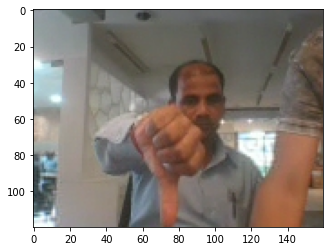

In [5]:
from skimage import io
sample_image_name = train_path + '/WIN_20180925_17_34_05_Pro_Thumbs_Down_new/WIN_20180925_17_34_05_Pro_00089.png'
sample_image = io.imread(sample_image_name)
print('Thumbs down image')
plt.imshow(sample_image)
plt.show()

Right Swipe image


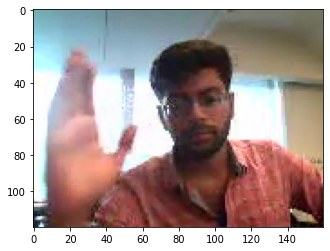

In [6]:
sample_image_name = train_path + '/WIN_20180925_17_34_40_Pro_Right_Swipe_new/WIN_20180925_17_34_40_Pro_00043.png'
sample_image = io.imread(sample_image_name)
# Original Image
print('Right Swipe image')
plt.imshow(sample_image)
plt.show()

Left Swipe image


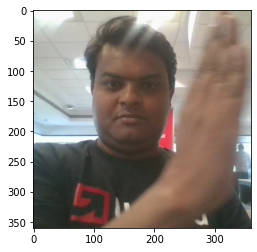

In [7]:
sample_image_name = train_path + '/WIN_20180907_15_52_28_Pro_Left Swipe_new_Left Swipe_new/WIN_20180907_15_52_28_Pro_00036.png'
sample_image = io.imread(sample_image_name)
# Original Image
print('Left Swipe image')
plt.imshow(sample_image)
plt.show()

Thumbs up image


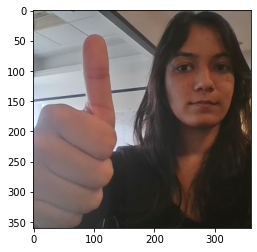

In [8]:
sample_image_name = train_path + '/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00069.png'
sample_image = io.imread(sample_image_name)
# Original Image
print('Thumbs up image')
plt.imshow(sample_image)
plt.show()

In [6]:
df = pd.read_csv(ROOT_DIR + '/train.csv', sep=';', header=None)
df = df.rename(columns={0:'Folder', 1: 'Gesture Label', 2: 'Gesture Class'})
df.head()

,Folder,Gesture Label,Gesture Class
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0


In [7]:
#Lets check how many gestures are there in dataset
df['Gesture Class'].unique()

array([0, 1, 2, 3, 4])

In [8]:
#Lets check the gesture label and class
df.groupby('Gesture Class')['Gesture Label', 'Gesture Class'].head(1)

,Gesture Label,Gesture Class
0,Left_Swipe_new,0
96,Right_Swipe_new,1
199,Stop_new,2
292,Thumbs_Down_new,3
392,Thumbs_Up_new,4


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
#Initialize Global variables
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
curr_dt_time = datetime.datetime.now()
num_epochs = 0
batch_size = 0
img_idx = []
x = len(img_idx) # Number of video frames needs to be used,
y = 0 # size of the input image frames of the videos(heigh),
z = 0 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation

In [10]:
def print_input_summary():
    print('# Time =', curr_dt_time)
    print('# training sequences =', num_train_sequences)
    print('# validation sequences =', num_val_sequences)
    print('# epochs =', num_epochs)
    print('# Image Index  = ', img_idx)
    print('# Number of Video Frames = ', x)
    print('# Image Size = ', (y,z))
    print('# batch size =', batch_size)
    print('# Augmentation =', augment)

### Plot accuracy graph

In [11]:
def plot_accuracy(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['train_loss','val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['Training Accuracy','Validation Accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

### Cropping image to center square

In [12]:
def crop_center_square(frame):
    y_, x_ = frame.shape[0:2]
    min_dim = min(y_, x_)
    start_x = (x_ // 2) - (min_dim // 2)
    start_y = (y_ // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [13]:
def generator(source_path, folder_list, batch_size):
    print('# Source path = ', source_path)
    print('# batch size =', batch_size)
    print('# Augmentation =', augment)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size)
        for batch in range(num_batches):

            batch_data = np.zeros((batch_size,len(img_idx),y,z,3))
            batch_labels = np.zeros((batch_size,5))

            if (augment): batch_data_aug = np.zeros((batch_size,len(img_idx),y,z,3))

            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(y,z,3))
                    if (augment):
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(y,z,3))

                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    else:
                        if (image.shape[0] == 120 and image.shape[1] == 160):
                            image_resized = resize(image[:,20:140,:],(y,z,3))
                        else:
                            image_resized = resize(image,(y,z,3))
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augment):
                    batch_data=np.concatenate([batch_data,batch_data_aug])
                    batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data,batch_labels

        remaining_seq=len(t)%batch_size
        if (remaining_seq != 0):
            seq_len = remaining_seq if remaining_seq else batch_size
            batch_data = np.zeros((seq_len,len(img_idx),y,z,3))
            batch_labels = np.zeros((seq_len,5))
            if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),y,z,3))
            for folder in range(seq_len):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(y,z,3))
                    if (augment):
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(y,z,3))

                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    else:
                        if (image.shape[0] == 120 and image.shape[1] == 160):
                            image_resized = resize(image[:,20:140,:],(y,z,3))
                        else:
                            image_resized = resize(image,(y,z,3))
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data,batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model-1: CNN Model
### Experiment 1: Generator function image resize
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.
### Decision:
-	Will use first 10 image frames from each video.
-	We will not crop any image, will just resize the images to size 180x180.


In [30]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 10
batch_size = 32
img_idx = [0,1,2,3,4,5,6,7,8,9]
x = len(img_idx) # Number of video frames needs to be used
y = 180 # size of the input image frames of the videos(heigh)
z = 180 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 11:59:06.213711
# training sequences = 663
# validation sequences = 100
# epochs = 10
# Image Index  =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Number of Video Frames =  10
# Image Size =  (180, 180)
# batch size = 32
# Augmentation = False


In [31]:
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [21]:
from keras import optimizers
from keras.optimizers import gradient_descent_v2
# Define optimizer with learning rate and other parameters
optimizer = gradient_descent_v2.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)

# Compile the model with the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 180, 180, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 10, 180, 180, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 10, 180, 180, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 90, 90, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 90, 90, 128)   221312    
                                                                 
 batch_normalization_1 (Batc  (None, 10, 90, 90, 128)  5

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
#Throwing OOM error as lot of parameters in the model. So, function is commented below.
'''
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
'''

'\nmodel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,\n                    callbacks=callbacks_list, validation_data=val_generator,\n                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)\n'

## Model-2: CNN Model
### Experiment 2: Generator function image resize & crop
### Decision:
-	Will use first 10 image frames from each video.
-	Per problem statement there are 2 dimensions of images present in data. 360x360 and 120x160.
-	We will crop 120x160 image to 120x120 to make it first symmetric in dimensions.
-	Resize all input images to 80x80. As Conv3D is prone to error with different shapes in data.
- Reducing the size of images to avoid GPU OOM error
- We will augment the image cropping to center square

In [32]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 10
batch_size = 32
img_idx = [0,1,2,3,4,5,6,7,8,9]
x = len(img_idx) # Number of video frames needs to be used
y = 80 # size of the input image frames of the videos(heigh)
z = 80 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 11:59:18.321612
# training sequences = 663
# validation sequences = 100
# epochs = 10
# Image Index  =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# Number of Video Frames =  10
# Image Size =  (80, 80)
# batch size = 32
# Augmentation = False


In [33]:
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [35]:
# Define optimizer with learning rate, momentum, and nesterov
from keras.optimizers import gradient_descent_v2
optimizer = gradient_descent_v2.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)

# Compile the model with the defined optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print model summary
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 10, 80, 80, 64)    5248      
                                                                 
 batch_normalization_5 (Batc  (None, 10, 80, 80, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 10, 80, 80, 64)    0         
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 10, 40, 40, 64)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 40, 40, 128)   221312    
                                                                 
 batch_normalization_6 (Batc  (None, 10, 40, 40, 128) 

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [36]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 32
# Augmentation = False
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 6.6605 - categorical_accuracy: 0.2624# Source path =  datasets/Project_data/val
# batch size = 32
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-1011_59_18.321612/model-00001-6.66049-0.26244-1.56129-0.28000.h5
21/21 [==============================] - 98s 5s/step - loss: 6.6605 - categorical_accuracy: 0.2624 - val_loss: 1.5613 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 2/10
11/21 [==============>...............] - ETA: 33s - loss: 1.4113 - categorical_accuracy: 0.3523

## Model-3: CNN Model
### Experiment 3: Generator function increase number of images in input & reduce filters in model

### Decision
-	Will use 18 image frames from each video.
-	Video has total 30 image frames. We divided these 30 images into 3 slots each 10 images. slot1 [0:9], slot2 [10:19], slot3 [20:29] In each slot we will take 6 images will select 2 images in beginning 2 images in ending and 2 images in middle so that in each slot we will have 6 so total 18 images.
-	Reduce filters in Conv3D layers.


In [34]:
#Set the global parameters
!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 10
batch_size = 32
img_idx = [0,1,4,5,8,9,10,11,14,15,18,19,20,21,24,25,28,29]
x = len(img_idx) # Number of video frames needs to be used
y = 80 # size of the input image frames of the videos(heigh)
z = 80 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-09 17:57:06.024606
# training sequences = 663
# validation sequences = 100
# epochs = 10
# Image Index  =  [0, 1, 4, 5, 8, 9, 10, 11, 14, 15, 18, 19, 20, 21, 24, 25, 28, 29]
# Number of Video Frames =  18
# Image Size =  (80, 80)
# batch size = 32
# Augmentation = False


In [35]:
model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [37]:
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 18, 80, 80, 32)    2624      
                                                                 
 batch_normalization_6 (Batc  (None, 18, 80, 80, 32)   128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 18, 80, 80, 32)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 18, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 18, 40, 40, 64)    55360     
                                                                 
 batch_normalization_7 (Batc  (None, 18, 40, 40, 64)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model with new generator parameters. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [41]:
'''
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
'''

'\nmodel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,\n                    callbacks=callbacks_list, validation_data=val_generator,\n                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)\n'

# Model-4: CNN Model
## Experiment 4: Generator function increase number of images in input , reduce the image size & increased filters in model
Decision:
-	Will use 18 image frames from each video.
-	Video has total 30 image frames. We divided these 30 images into 3 slots each 10 images. slot1 [0:9], slot2 [10:19], slot3 [20:29] In each slot we will take 6 images will select 2 images in beginning 2 images in ending and 2 images in middle so that in each slot we will have 6 so total 18 images.
-	Reduce the image size from 80x80 to 60x60
-	Increase filters in Conv3D layers.
- Number of Epochs will be 30
- Will do image cropping here

In [42]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30
batch_size = 20
img_idx = [0,1,4,5,8,9,10,11,14,15,18,19,20,21,24,25,28,29]
x = len(img_idx) # Number of video frames needs to be used
y = 60 # size of the input image frames of the videos(heigh)
z = 60 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-09 17:57:32.506698
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 1, 4, 5, 8, 9, 10, 11, 14, 15, 18, 19, 20, 21, 24, 25, 28, 29]
# Number of Video Frames =  18
# Image Size =  (60, 60)
# batch size = 20
# Augmentation = False


In [43]:
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [44]:
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 60, 60, 64)    5248      
                                                                 
 batch_normalization_9 (Batc  (None, 18, 60, 60, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 18, 60, 60, 64)    0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 18, 30, 30, 64)   0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 18, 30, 30, 128)   221312    
                                                                 
 batch_normalization_10 (Bat  (None, 18, 30, 30, 128) 

In [45]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [46]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
'''
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
'''

'\nmodel.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,\n                    callbacks=callbacks_list, validation_data=val_generator,\n                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)\n'

## Model-5: CNN Model
### Experiment 5a: Generator function maximize batch size such way that we are able use GPU to full capacity.
### Experiment 5b: Generator function use batch size greater than 32 and less than 96 and also reduced the filters in Conv3D layers.
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Increase batch size to 128 and then 96
- After setting the batch size 128 or 96 we gets the error. Hence we will set batch size to 64 & Epoch to 30
- Will keep image size same 60x60


In [49]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
x = len(img_idx) # Number of video frames needs to be used
y = 60 # size of the input image frames of the videos(heigh)
z = 60 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-09 17:57:45.569292
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (60, 60)
# batch size = 20
# Augmentation = False


In [50]:
model = Sequential()
model.add(Conv3D(32, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2), strides=(1,2,2), padding='same'))

model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [52]:
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 15, 60, 60, 32)    2624      
                                                                 
 batch_normalization_12 (Bat  (None, 15, 60, 60, 32)   128       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 30, 30, 32)   0         
 3D)                                                             
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 30, 30, 64)    55360     
                                                                 
 batch_normalization_13 (Bat  (None, 15, 30, 30, 64)  

In [53]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [54]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [55]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = False
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.4480 - categorical_accuracy: 0.3801# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-0917_57_45.569292/model-00001-2.44797-0.38009-1.61394-0.21000.h5
34/34 [==============================] - 151s 5s/step - loss: 2.4480 - categorical_accuracy: 0.3801 - val_loss: 1.6139 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2729 - categorical_accuracy: 0.4525
Epoch 00002: saving model to model_init_2024-02-0917_57_45.569292/model-00002-1.27287-0.45249-2.78093-0.20000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.2729 - categorical_accuracy: 0.4525 - val_loss: 2.7809 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0

## Model-6: CNN + RNN Modle with LSTM
### Experiment 6: CCN + RNN Model with LSTM.
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will keep image size to 60x60
-	batch size will be 64.
-	The recurrent connections often offer advantages. They make every unit to use their context information and especially in image recognition tasks this is very helpful. As the time steps increase, the unit gets influenced by larger and larger neighborhood. With that information recurrent networks can watch large regions in the input space. In CNN this ability is limited to units in higher layers.
-	Recurrent connections yield to an ability of handling sequential data.
-	We will be using LSTM to solve vanishing gradient problem or exploding gradient problem.

In [14]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
x = len(img_idx) # Number of video frames needs to be used
y = 60 # size of the input image frames of the videos(heigh)
z = 60 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 02:07:36.041476
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (60, 60)
# batch size = 20
# Augmentation = False


In [15]:
# Define some more local variables
lstm_cells=64
dense_neurons=64
dropout=0.25
num_classes=5

model = Sequential()

model.add(
    TimeDistributed(
        Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(x,y,z,3)
        ))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

2024-02-10 02:07:37.517452: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-10 02:07:37.517535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [17]:

from keras.optimizers import gradient_descent_v2
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 60, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 60, 60, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 30, 30, 32)   1

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = False
Epoch 1/30


2024-02-10 02:08:41.685729: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6414 - categorical_accuracy: 0.2247# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-1002_07_36.041476/model-00001-1.64140-0.22474-1.62452-0.16000.h5
34/34 [==============================] - 157s 5s/step - loss: 1.6414 - categorical_accuracy: 0.2247 - val_loss: 1.6245 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5358 - categorical_accuracy: 0.3152
Epoch 00002: saving model to model_init_2024-02-1002_07_36.041476/model-00002-1.53584-0.31523-1.65292-0.13000.h5
34/34 [==============================] - 146s 4s/step - loss: 1.5358 - categorical_accuracy: 0.3152 - val_loss: 1.6529 - val_categorical_accuracy: 0.1300 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.4698 - categorical_accuracy: 0.3424
Epoch 00003: saving model to model_init_2024-02-1

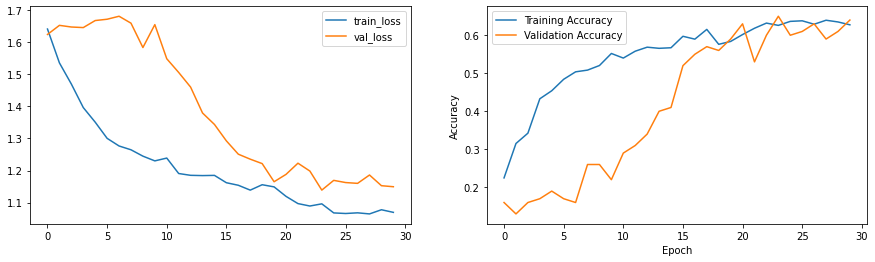

In [22]:
#Plot the accuracy of model.
plot_accuracy(model_history)

## Model-7: CNN + RNN with LSTM
### Experiment 7: CNN + RNN Model(LSTM) with increased image size.
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will increase image size to 80x80
-	batch size will be 64.
-	We will use LSTM in this model like experiment 6.

In [23]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30 # only two in crease for final run
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] # reducing thsi also to speed it up
x = len(img_idx) # Number of video frames needs to be used
y = 80 # size of the input image frames of the videos(heigh)
z = 80 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 03:22:01.757749
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (80, 80)
# batch size = 20
# Augmentation = False


In [24]:
# Define some more local variables
lstm_cells=64
dense_neurons=64
dropout=0.25
num_classes=5

model = Sequential()

model.add(
    TimeDistributed(
        Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(x,y,z,3)
        ))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

In [25]:
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 40, 40, 32)  

In [26]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [27]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = False
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6527 - categorical_accuracy: 0.2187# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-1003_22_01.757749/model-00001-1.65267-0.21870-1.62292-0.18000.h5
34/34 [==============================] - 138s 4s/step - loss: 1.6527 - categorical_accuracy: 0.2187 - val_loss: 1.6229 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5195 - categorical_accuracy: 0.3062
Epoch 00002: saving model to model_init_2024-02-1003_22_01.757749/model-00002-1.51955-0.30618-1.66015-0.18000.h5
34/34 [==============================] - 135s 4s/step - loss: 1.5195 - categorical_accuracy: 0.3062 - val_loss: 1.6601 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0

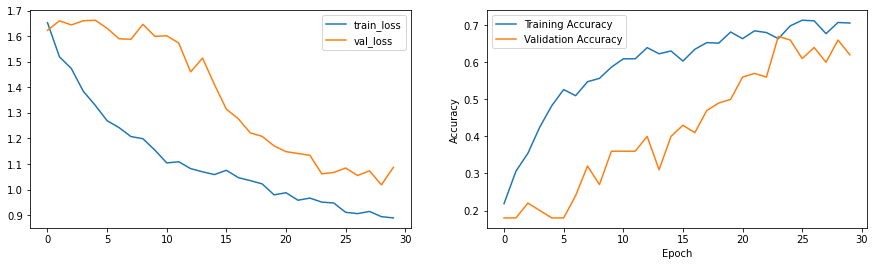

In [30]:
#Plot the accuracy of model.
plot_accuracy(model_history)

## Model-8:  CNN + RNN Model with GRU
### Experiment 8:  CNN + RNN Model with GRU
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will increase image size to 120x120
-	batch size will be 64.
-	We will use GRU in this model.
-	Finally, you briefly saw an LSTM variant - the gated recurrent unit (GRU). A GRU network consists of GRU layers which consist of GRU cells which are like LSTM cells. However, the GRU has fewer parameters than an LSTM network. A GRU has three weight matrices as compared to the four in an LSTM layer.
-	This means that a GRU has 3x parameters than a vanilla RNN layer.

In [16]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30 # only two in crease for final run
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] # reducing thsi also to speed it up
x = len(img_idx) # Number of video frames needs to be used
y = 120 # size of the input image frames of the videos(heigh)
z = 120 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 06:35:51.772924
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (120, 120)
# batch size = 20
# Augmentation = False


In [17]:
# Define some more local variables
gru_cells=64
dense_neurons=64
dropout=0.25
num_classes=5

model = Sequential()

model.add(
    TimeDistributed(
        Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(x,y,z,3)
        ))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(gru_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

2024-02-10 06:35:53.959460: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-10 06:35:53.959523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22849 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [18]:
from keras.optimizers import adam_v2
optimiser = adam_v2.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 60, 60, 32)   1

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = False
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.4807 - categorical_accuracy: 0.3333# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-1005_08_14.857950/model-00001-1.48069-0.33333-2.54329-0.21000.h5
34/34 [==============================] - 135s 4s/step - loss: 1.4807 - categorical_accuracy: 0.3333 - val_loss: 2.5433 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1963 - categorical_accuracy: 0.4917
Epoch 00002: saving model to model_init_2024-02-1005_08_14.857950/model-00002-1.19627-0.49170-3.02307-0.18000.h5
34/34 [==============================] - 129s 4s/step - loss: 1.1963 - categorical_accuracy: 0.4917 - val_loss: 3.0231 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0

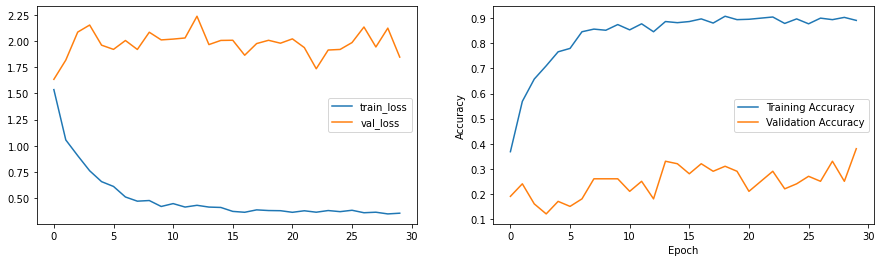

In [ ]:
#Plot the accuracy of model.
plot_accuracy(model_history)

## Model-9: Transfer Learning with VGG16.
### Experiment 9: Transfer Learning with VGG16 and GRU.  
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will use image shape to 120x120
-	batch size will be 64.
-	We will use heavy duty transfer learning architectures like VGG16 with GRU in this model.


In [20]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30 # only two in crease for final run
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] # reducing thsi also to speed it up
x = len(img_idx) # Number of video frames needs to be used
y = 120 # size of the input image frames of the videos(heigh)
z = 120 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 06:36:13.482328
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (120, 120)
# batch size = 20
# Augmentation = False


In [21]:
vgg16_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
base_model = vgg16_model.output
base_model = Flatten()(base_model)
features = Dense(64, activation='relu')(base_model)
conv_model = Model(inputs=vgg16_model.input, outputs=features)

for layer in vgg16_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(x,y,z,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

58900480/58889256 [==============================] - 4s 0us/step


In [29]:
from keras.optimizers import gradient_descent_v2
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 64)           15009664  
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_2 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 5)                 45        
                                                      

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = False
Epoch 1/30


2024-02-10 06:38:52.910436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6263 - categorical_accuracy: 0.1885# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-1006_36_13.482328/model-00001-1.62633-0.18854-1.60967-0.17000.h5
34/34 [==============================] - 138s 4s/step - loss: 1.6263 - categorical_accuracy: 0.1885 - val_loss: 1.6097 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6151 - categorical_accuracy: 0.1765
Epoch 00002: saving model to model_init_2024-02-1006_36_13.482328/model-00002-1.61505-0.17647-1.60902-0.22000.h5
34/34 [==============================] - 130s 4s/step - loss: 1.6151 - categorical_accuracy: 0.1765 - val_loss: 1.6090 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.6034 - categorical_accuracy: 0.2217
Epoch 00003: saving model to model_init_2024-02-1

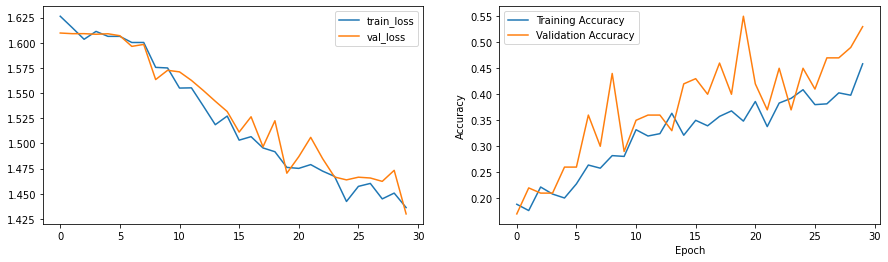

In [34]:
#Plot the accuracy of model.
plot_accuracy(model_history)

## Model-10: Transfer Learning with Mobilenet.
### Experiment 10: Transfer Learning with Mobilenet and LSTM.  
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will use image shape to 120x120
-	batch size will be 64.
-	We will use light weight transfer learning architectures like Mobilenet with LSTM in this model.

In [35]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30 # only two in crease for final run
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] # reducing thsi also to speed it up
x = len(img_idx) # Number of video frames needs to be used
y = 120 # size of the input image frames of the videos(heigh)
z = 120 # size of the input image frames of the videos(width)
augment = False #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 07:42:19.403301
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (120, 120)
# batch size = 20
# Augmentation = False


In [36]:
# Define some more local variables
lstm_cells=128
dense_neurons=128
dropout=0.25

#mobilenet_transfer = MobileNetV2(weights='imagenet', include_top=False, input_shape=(y, z, 3))
mobilenet_transfer = mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(y, z, 3), alpha=1.0, depth_multiplier=1)
#feature_model.load_weights('mobilenet_1_0_224_tf.h5') # give the path for downloaded weights

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(5, activation='softmax'))

17235968/17225924 [==============================] - 2s 0us/step


In [37]:
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)              

In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = False
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.7066 - categorical_accuracy: 0.1931# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = False

Epoch 00001: saving model to model_init_2024-02-1007_42_19.403301/model-00001-1.70659-0.19306-1.61851-0.30000.h5
34/34 [==============================] - 133s 4s/step - loss: 1.7066 - categorical_accuracy: 0.1931 - val_loss: 1.6185 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6313 - categorical_accuracy: 0.2323
Epoch 00002: saving model to model_init_2024-02-1007_42_19.403301/model-00002-1.63133-0.23228-1.52527-0.39000.h5
34/34 [==============================] - 128s 4s/step - loss: 1.6313 - categorical_accuracy: 0.2323 - val_loss: 1.5253 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0

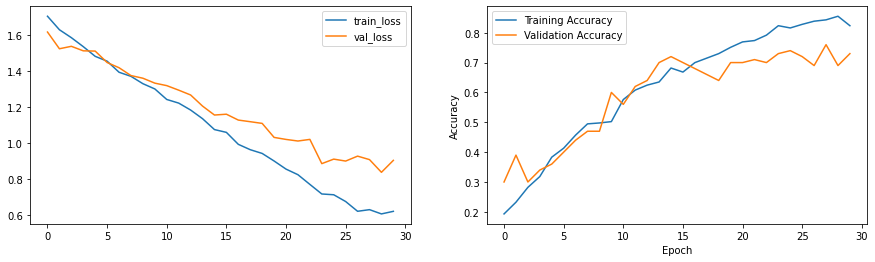

In [42]:
#Plot the accuracy of model.
plot_accuracy(model_history)

## Model-11: CNN + RNN Model with LSTM
### Experiment 11: CNN + RNN Model(LSTM) with augmentation image size.
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will keep image size to 120x120.
-	We will use image cropping augmentation in this experiment. Let’s see if this solves the model overfitting problem in experiment 7.
-	batch size will be 64.
-	We will use LSTM in this model like experiment 7.

In [43]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 30 # only two in crease for final run
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] # reducing thsi also to speed it up
x = len(img_idx) # Number of video frames needs to be used
y = 120 # size of the input image frames of the videos(heigh)
z = 120 # size of the input image frames of the videos(width)
augment = True #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 08:52:10.115204
# training sequences = 663
# validation sequences = 100
# epochs = 30
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (120, 120)
# batch size = 20
# Augmentation = True


In [44]:
# Define some more local variables
lstm_cells=128
dense_neurons=128
dropout=0.25
num_classes=5

model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
        input_shape=(x,y,z,3)
        ))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

In [45]:
optimiser = gradient_descent_v2.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 60, 60, 32)  

In [46]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [47]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [48]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [49]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = True
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6026 - categorical_accuracy: 0.2496# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = True

Epoch 00001: saving model to model_init_2024-02-1008_52_10.115204/model-00001-1.60256-0.24962-1.61624-0.20500.h5
34/34 [==============================] - 173s 5s/step - loss: 1.6026 - categorical_accuracy: 0.2496 - val_loss: 1.6162 - val_categorical_accuracy: 0.2050 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4038 - categorical_accuracy: 0.4118
Epoch 00002: saving model to model_init_2024-02-1008_52_10.115204/model-00002-1.40380-0.41176-1.59292-0.24500.h5
34/34 [==============================] - 166s 5s/step - loss: 1.4038 - categorical_accuracy: 0.4118 - val_loss: 1.5929 - val_categorical_accuracy: 0.2450 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s 

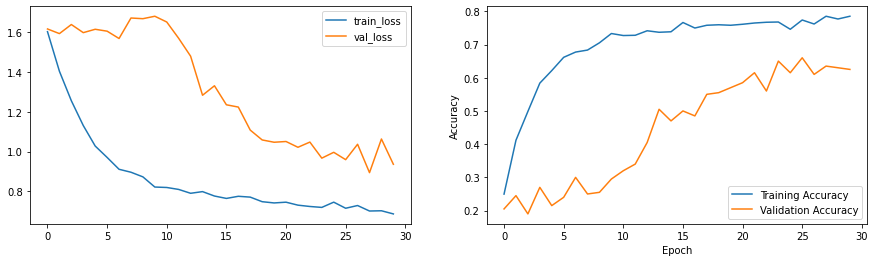

In [50]:
#Plot the accuracy of model.
plot_accuracy(model_history)

## Final Model-12:  Transfer Learning with Mobilenet.
### Final Experiment 12: Transfer Learning with MobileNet and LSTM with more augmentation.
### Decision:
-	Will use 15 image frames from each video.
-	Video has total 30 image frames. We will use alternate image from 30 images.
-	Will increase image size to 120x120
-	batch size will be 64.
-	We will use LSTM in this model.
- We will do more image augmentation in this experiment

In [20]:
def generator(source_path, folder_list, batch_size):
    print('# Source path = ', source_path)
    print('# batch size =', batch_size)
    print('# Augmentation =', augment)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size)
        for batch in range(num_batches):

            batch_data = np.zeros((batch_size,len(img_idx),y,z,3))
            batch_labels = np.zeros((batch_size,5))

            if (augment): batch_data_aug = np.zeros((batch_size,len(img_idx),y,z,3))

            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(y,z,3))
                    if (augment):
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(y,z,3))
                        M = cv2.getRotationMatrix2D((z//2,y//2), np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, M, (y, z))

                        batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

                    else:
                        if (image.shape[0] == 120 and image.shape[1] == 160):
                            image_resized = resize(image[:,20:140,:],(y,z,3))
                        else:
                            image_resized = resize(image,(y,z,3))
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augment):
                    batch_data=np.concatenate([batch_data,batch_data_aug])
                    batch_labels=np.concatenate([batch_labels,batch_labels])

            yield batch_data,batch_labels

        remaining_seq=len(t)%batch_size
        if (remaining_seq != 0):
            seq_len = remaining_seq if remaining_seq else batch_size
            batch_data = np.zeros((seq_len,len(img_idx),y,z,3))
            batch_labels = np.zeros((seq_len,5))
            if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),y,z,3))
            for folder in range(seq_len):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    #performing image reading and resizing
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resized = resize(image,(y,z,3))
                    if (augment):
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                        shifted = cv2.warpAffine(image,
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]),
                                                (image.shape[1], image.shape[0]))

                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0)
                        # cropping the images to have the targeted gestures and remove the noise from the images.
                        cropped=shifted[x0:x1,y0:y1,:]

                        image_resized=resize(cropped,(y,z,3))
                        M = cv2.getRotationMatrix2D((z//2,y//2), np.random.randint(-10,10), 1.0)
                        rotated = cv2.warpAffine(image_resized, M, (y, z))

                        batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255

                    else:
                        if (image.shape[0] == 120 and image.shape[1] == 160):
                            image_resized = resize(image[:,20:140,:],(y,z,3))
                        else:
                            image_resized = resize(image,(y,z,3))
                        #normalizing the images
                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            yield batch_data,batch_labels

In [21]:
#Set the global parameters
#!rm -rf model*
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)
num_epochs = 20 # only two in crease for final run
batch_size = 20
img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] # reducing thsi also to speed it up
x = len(img_idx) # Number of video frames needs to be used
y = 120 # size of the input image frames of the videos(heigh)
z = 120 # size of the input image frames of the videos(width)
augment = True #Enable True if want to do image augmentation
print_input_summary()

# Time = 2024-02-10 10:58:06.502772
# training sequences = 663
# validation sequences = 100
# epochs = 20
# Image Index  =  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
# Number of Video Frames =  15
# Image Size =  (120, 120)
# batch size = 20
# Augmentation = True


In [22]:
# Define some more local variables
lstm_cells=64
dense_neurons=64
dropout=0.25

mobilenet_transfer = mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(y, z, 3), alpha=1.0, depth_multiplier=1)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(x,y,z,3)))

for layer in model.layers:
    layer.trainable = False

model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(dropout))

model.add(Dense(dense_neurons,activation='relu'))
model.add(Dropout(dropout))

model.add(Dense(5, activation='softmax'))

In [23]:
from keras.optimizers import adam_v2
optimiser = adam_v2.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 15, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 1024)         0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 64)               

In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [27]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# Source path =  datasets/Project_data/train
# batch size = 20
# Augmentation = True
Epoch 1/20


2024-02-10 10:58:20.352392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.5120 - categorical_accuracy: 0.3552# Source path =  datasets/Project_data/val
# batch size = 20
# Augmentation = True

Epoch 00001: saving model to model_init_2024-02-1010_58_06.502772/model-00001-1.51197-0.35520-1.18317-0.57500.h5
34/34 [==============================] - 178s 5s/step - loss: 1.5120 - categorical_accuracy: 0.3552 - val_loss: 1.1832 - val_categorical_accuracy: 0.5750 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0594 - categorical_accuracy: 0.5958
Epoch 00002: saving model to model_init_2024-02-1010_58_06.502772/model-00002-1.05941-0.59578-0.88381-0.68500.h5
34/34 [==============================] - 166s 5s/step - loss: 1.0594 - categorical_accuracy: 0.5958 - val_loss: 0.8838 - val_categorical_accuracy: 0.6850 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.7592 - categorical_accuracy: 0.7262
Epoch 00003: saving model to model_init_2024-02-10

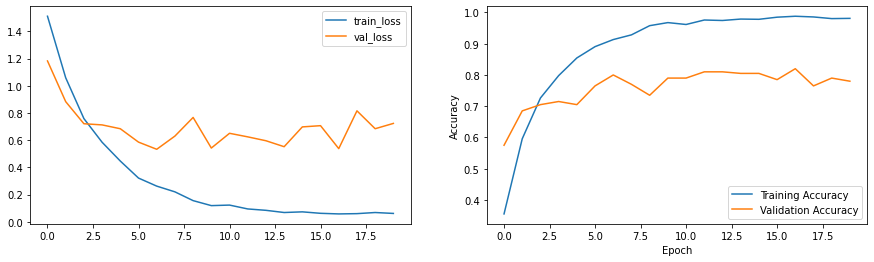

In [28]:
#Plot the accuracy of model.
plot_accuracy(model_history)